In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error

## Data Extraction

In [2]:
def read_data(filename):
    return pd.read_parquet(filename)

Refer to the experiments notebook for the reasons behind said transformations/extraction

In [3]:
def extract_columns(df):
    numerical_feats = ['trip_distance', 'fare_amount']
    categorical_feats = ['PULocationID', 'DOLocationID']
    timed_feats = ['lpep_pickup_datetime', 'lpep_dropoff_datetime'] 

    df = df[categorical_feats + timed_feats + numerical_feats].copy()

    # Convert from string to date time format
    df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
    df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])

    # Create a new column called duration (in minutes)
    df['duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime'])
    df['duration'] = df['duration'].dt.total_seconds() / 60

    # Drop the time cols since they are no longer needed
    df = df.drop(['lpep_pickup_datetime', 'lpep_dropoff_datetime'], axis=1)

    # Convert to string (they are in integer right now)
    df[categorical_feats] = df[categorical_feats].astype('string')

    # Concatenate cat vars
    df['PUDOLocationID'] = df['PULocationID'] + '_' + df['DOLocationID']

    # Delete cat vars
    df = df.drop(['PULocationID', 'DOLocationID'], axis=1)

    # Drop duplicates
    df = df.drop_duplicates()

    return df



In [4]:
def filter_data(df):
    
    # Drop records with "abnormal" values
    df = df[(df['fare_amount'] > 0.0) & 
          (df['trip_distance'] > 0.0) &
          (df['duration'] > 0.0)]
    
    # Filter the DataFrame to exclude outliers
    df = df[(df['trip_distance'] <= 14)]

    df = df[df['fare_amount'] <= 30]

    df = df[df['duration'] < 27]

    return df

In [5]:
df_train = read_data('data/classwork/green_tripdata_2023-01.parquet')
df_train = extract_columns(df_train)
df_train = filter_data(df_train)

In [6]:
X_train = df_train.drop(['duration'], axis=1)
y_train = df_train['duration'].values

In [7]:
dv = DictVectorizer()
X_train = dv.fit_transform(X_train.to_dict(orient='records'))

## Linear Regression - Training

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

## Ridge Regression - Training

In [9]:
rd = Ridge(alpha=0.00001)
rd.fit(X_train, y_train)

Ridge(alpha=1e-05)

## Lasso Regression - Training

In [10]:
ls = Lasso(alpha=0.001)
ls.fit(X_train, y_train)

Lasso(alpha=0.001)

In [11]:
df_val = read_data('data/classwork/green_tripdata_2023-02.parquet')
df_val = extract_columns(df_val)
df_val = filter_data(df_val)

In [12]:
df_train

,trip_distance,fare_amount,duration,PUDOLocationID
0,2.58,14.90,11.016667,166_143
1,1.81,10.70,6.766667,24_43
3,1.30,6.50,5.816667,41_238
4,1.10,6.00,5.966667,41_74
5,2.78,17.70,17.550000,41_262
...,...,...,...,...
68205,3.92,20.72,18.000000,75_186
68207,2.14,4.41,8.000000,10_205
68208,3.44,16.53,16.000000,66_37
68209,3.03,14.98,18.000000,225_189


In [13]:
X_test = df_val.drop(['duration'], axis=1)
y_test = df_val['duration'].values

In [14]:
X_test = dv.transform(X_test.to_dict(orient='records'))

## Linear Regression - Validation

Text(0.5, 1.0, 'Linear Regression - mse: 2.5334336267987982')

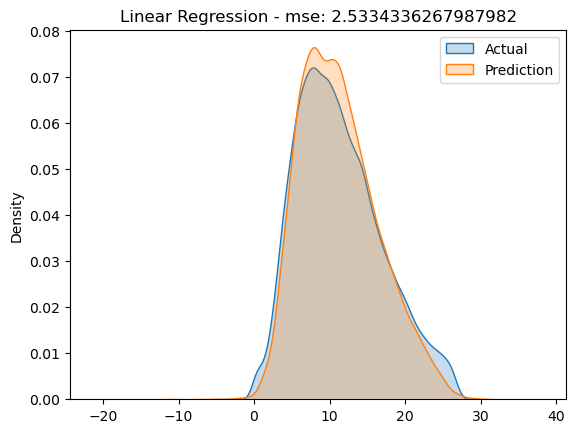

In [15]:
lr_pred = lr.predict(X_test)

mse_lr = mean_squared_error(y_test, lr_pred, squared=False)

sns.kdeplot(y_test, label='Actual', fill=True)
sns.kdeplot(lr_pred, label='Prediction', fill=True)

plt.legend()
plt.title("Linear Regression - mse: " + str(mse_lr))

## Ridge Regression - Validation

Text(0.5, 1.0, 'Linear Regression - mse: 2.5367675368200397')

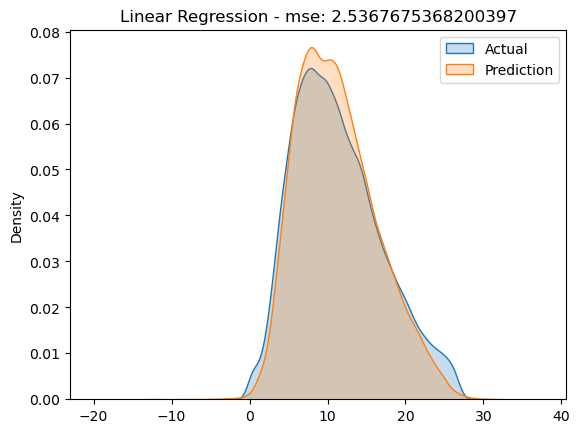

In [16]:
rd_pred = rd.predict(X_test)

mse_rd = mean_squared_error(y_test, rd_pred, squared=False)

sns.kdeplot(y_test, label='Actual', fill=True)
sns.kdeplot(rd_pred, label='Prediction', fill=True)

plt.legend()
plt.title("Linear Regression - mse: " + str(mse_rd))

## Lasso Regression - Validation

Text(0.5, 1.0, 'Linear Regression - mse: 2.6129753162048783')

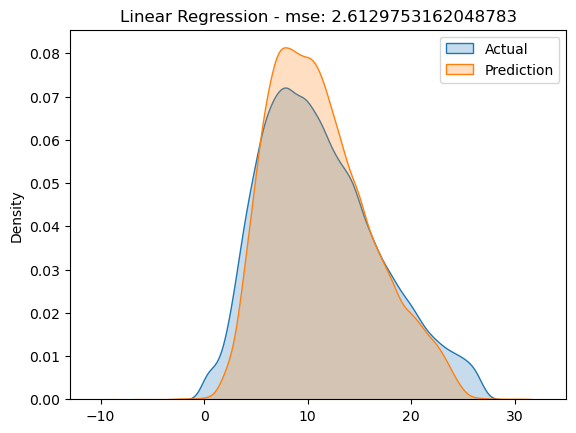

In [17]:
ls_pred = ls.predict(X_test)

mse_ls = mean_squared_error(y_test, ls_pred, squared=False)

sns.kdeplot(y_test, label='Actual', fill=True)
sns.kdeplot(ls_pred, label='Prediction', fill=True)

plt.legend()
plt.title("Linear Regression - mse: " + str(mse_ls))

## Final Words

From the results above, we can conclude that our model performs well, since we are only off by 2 minutes